In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [2]:
!pwd

/home/advice/Python/SR/SubProject/2020/BayesianNN


In [3]:
data_path = "/home/advice/Python/SR/SubProject/2020/03/data/korean_stock/한미반도체_일봉데이터.csv"
df = pd.read_csv(data_path)
col = df.columns.tolist()
## https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231#JNJ_2006-01-01_to_2018-01-01.csv

In [4]:
if 'Unnamed: 0' in col :
    df = df.rename(columns = {'Unnamed: 0' : "date"})
a = ['date', 'open', 'high', 'low', 'close', 'volume']
b = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.rename(columns= dict(zip(a,b)))
df.Date = pd.to_datetime(df.Date, format='%Y%m%d')
df.sort_values("Date",ascending=True , inplace=True)
df = df[df.Date > "2000-01-01"]
df.reset_index(drop=True , inplace=True)

In [5]:
# close_prices = df["Close"]
# scaler = StandardScaler()
# close_prices_arr = np.array(close_prices).reshape(-1, 1)
# close_prices = scaler.fit_transform(close_prices_arr)
# close_prices_unscaled = df["Close"]

In [6]:
scaler = StandardScaler()
ycol = ["Close"]
xcol = ['Open', 'High', 'Low', 'Close', 'Volume']
xxcol = ['Open', 'High', 'Low', 'Volume']
close_prices_unscaled = df["Close"]
df[xxcol] = scaler.fit_transform(df[xxcol])
y_scaler = StandardScaler()
df[ycol] = y_scaler.fit_transform(df[ycol])

In [7]:
from tqdm import tqdm_notebook
def build_timeseries(data:pd.DataFrame, ycol:list, 
                     TIME_STEPS:int,usecol, 
                     predict_day:int=1, 
                     date_col:str=None):
    mat = data[usecol].values
    Date = data[date_col].astype(str).values.tolist()
    yy = data[ycol].values.reshape(-1,1)
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS - predict_day
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = []
    date = []
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:(TIME_STEPS+i)]
        if predict_day == 1 :
            _y = yy[i+ TIME_STEPS+predict_day-1]
            _date = Date[i+ TIME_STEPS+predict_day-1]
        elif predict_day == 30 :
            _y = yy[i+ TIME_STEPS+predict_day-1]
            _date = Date[i+ TIME_STEPS+predict_day-1]
        else :
            _y = yy[(i+TIME_STEPS):(i+predict_day+TIME_STEPS)]
            _date = Date[(i+TIME_STEPS):(i+predict_day+TIME_STEPS)]
        y.append(_y)
        date.append(_date)
    
    features = torch.tensor(x).float()
    labels = torch.tensor(np.asarray(y)).float()
    
    print("length of time-series i/o",x.shape,np.asarray(y).shape)
    return features , labels , np.asarray(date)

In [8]:
@variational_estimator
class NN(nn.Module):
    def __init__(self, usecol_n):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(usecol_n, 10)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [9]:
TIME_STEPS = 17
predict_day = 1
dataX , dataY ,dataDate = build_timeseries(data=df , ycol = "Close",
                                     TIME_STEPS=TIME_STEPS,
                                     predict_day=predict_day,
                                     usecol =xcol,
                                     date_col = "Date")
dataDate = dataDate.reshape(-1,1)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (3334, 17, 5) (3334, 1)


In [10]:
n = 200
date_col = "Date"
time_seq = df[date_col].shift(-(predict_day+ TIME_STEPS)).dropna().astype(str).values.tolist()
X_train ,  y_train, trainDate =dataX[:-n,:,:] , dataY[:-n,:]  , dataDate[:-n,:]
X_test , y_test , testDate =dataX[-n:,:,:] , dataY[-n:,:] , dataDate[-n:,:]

In [11]:
ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)
net = NN(len(xcol))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
# lstm_1 = BayesianLSTM(5, 10)
# lstm_1(X_train)

In [14]:
iteration = 0
for epoch in range(50):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3)
        loss.backward()
        optimizer.step()
        
#         iteration += 1
    if epoch % 10 ==0:
        preds_test = net(X_test)[:,0].unsqueeze(1)
        loss_test = criterion(preds_test, y_test)
        print("Epoch: {} Val-loss: {:.4f}".format(str(epoch), loss_test))

Iteration: 0 Val-loss: 0.0228
Iteration: 10 Val-loss: 0.0193
Iteration: 20 Val-loss: 0.0357
Iteration: 30 Val-loss: 0.0219
Iteration: 40 Val-loss: 0.0738


In [15]:

#pred_unscaled
original = close_prices_unscaled[1:][TIME_STEPS:]

df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [23]:
def pred_stock_future(X_test,future_length,sample_nbr=10,TIME_STEPS=None):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global X_train
    global dataX
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=TIME_STEPS)

    idx_pred = np.arange(len(X_train), len(dataX))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
#         as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        as_net_input = X_test[[i],:,:]
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=TIME_STEPS)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [24]:
def get_confidence_intervals(preds_test, ci_multiplier,scaler):
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [25]:
future_length=7
sample_nbr=4
ci_multiplier=10
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr, TIME_STEPS=TIME_STEPS)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled =\
get_confidence_intervals(preds_test,ci_multiplier, y_scaler)

In [26]:
y = df.iloc[idx_pred,:]["Close"].values.reshape(-1,1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.0 our predictions are in our confidence interval


In [27]:
upper_bound_unscaled.shape

(200, 1)

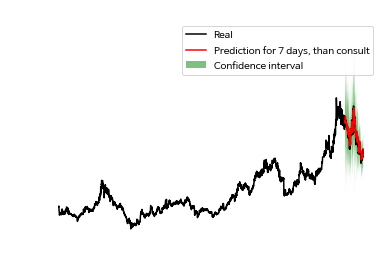

In [28]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

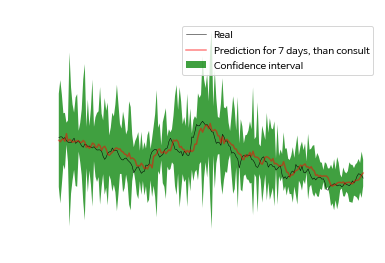

In [31]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()